# Trends in Caribbean early-season rainfall

Plot the temporal and spatial trends in monthly tropical North Atlantic sea surface temperatures and precipitation rates using NOAA [Extended Reconstructed SST version 5 (ERSSTv5)](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) and [Global Precipitation Climatology Project (GPCP)](https://psl.noaa.gov/data/gridded/data.gpcp.html).

In [1]:
# Package imports
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import cmaps as ncl_cm
import pymannkendall as mk

from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker


In [ ]:
# Define AxesGrid parameters to set map projections and orientation
projection = ccrs.PlateCarree(central_longitude=-180)
mproj = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(projection=projection))

## Retrieve data

The trends and p-values at each grid point is calculated for each variable. The function used to calculate the trend data can be found in `xarray_linear_trend.py`.

In [4]:
# ERSST, GPCC observations-based datasets
ds_sst = xr.open_dataset('../data/ersstv5_monthly_NorthAtlantic_ssts.nc')
ds_prcp = xr.open_dataset('../data/gpcp_monthly_NorthAtlantic_precip.nc')

# Seasonal trend fields
sst_trend_results = xr.open_dataset('../data/ersstv5_sst_MJJ_trend_results_1979to2024.nc')
prcp_trend_results = xr.open_dataset('../data/prcp_MJJ_trend_results_1979to2024.nc')

### Calculate the SST trend

In [5]:
## Calculate the tropical North Atlantic mean and reshape from 1D to 2D
# Caribbean-averaged wind time series
years = np.arange(1979, 2025, 1)
tna_ssts_2d_array = np.empty((2, len(years), 12))
tna_ssts = ds_sst.sst.sel(time=ds_sst.time.dt.year.isin(np.arange(1979, 2025, 1)), lat=slice(25, 5), lon=slice(360-80, 360-15)).mean(dim=['lat', 'lon'])

# Create a YxM wind array, where Y is the year and M are the months of that year
years = np.unique(tna_ssts.time.dt.year.values)
tna_ssts_2d = np.empty((len(years), 12))

for i in range(len(years)):
  # Get SST data for the current year
  sst_in_a_year = tna_ssts.sel(time=tna_ssts.time.dt.year.isin([years[i]])).values

  # Check if sst_year has data for all 12 months
  if len(sst_in_a_year) == 12:
    tna_ssts_2d[i, :] = sst_in_a_year  # Assign if it has 12 months of data
  else:
    # Handle cases where data is missing for some months
    # For example, you could fill the missing values with NaN
    tna_ssts_2d[i, :] = np.nan  # Fill with NaN if not 12 months

# For later
tna_ssts_2d_array[0, :, :] = tna_ssts_2d

# Find linear trend in cs_winds
tna_ssts_trend = np.polyfit(np.arange(0, len(tna_ssts.time)), tna_ssts, 1)
tna_ssts_trend_line = np.polyval(tna_ssts_trend, np.arange(0, len(tna_ssts.time)))

### Calculate the PRECIP trend

In [6]:
## Calculate the tropical North Atlantic mean and reshape from 1D to 2D
# Caribbean-averaged wind time series
years = np.arange(1979, 2025, 1)
tna_prcp_2d_array = np.empty((2, len(years), 12))
tna_prcp = ds_prcp.precip.sel(time=ds_prcp.time.dt.year.isin(np.arange(1979, 2025, 1)), lat=slice(5, 25), lon=slice(360-80, 360-15)).mean(dim=['lat', 'lon'])

# Create a YxM wind array, where Y is the year and M are the months of that year
years = np.unique(tna_prcp.time.dt.year.values)
tna_prcp_2d = np.empty((len(years), 12))

for i in range(len(years)):
  # Get SST data for the current year
  prcp_in_a_year = tna_prcp.sel(time=tna_prcp.time.dt.year.isin([years[i]])).values

  # Check if sst_year has data for all 12 months
  if len(prcp_in_a_year) == 12:
    tna_prcp_2d[i, :] = prcp_in_a_year  # Assign if it has 12 months of data
  else:
    # Handle cases where data is missing for some months
    # For example, you could fill the missing values with NaN
    tna_prcp_2d[i, :] = np.nan  # Fill with NaN if not 12 months

# For later
tna_prcp_2d_array[0, :, :] = tna_prcp_2d


## Generate plot of trends
Now, combine trends into one plot.

/Users/jjpjones/miniconda3/envs/breaking-env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/9r/1fy75c596lz3lxy_jxjy5g_r0002g0/T/ipykernel_68193/2883855570.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


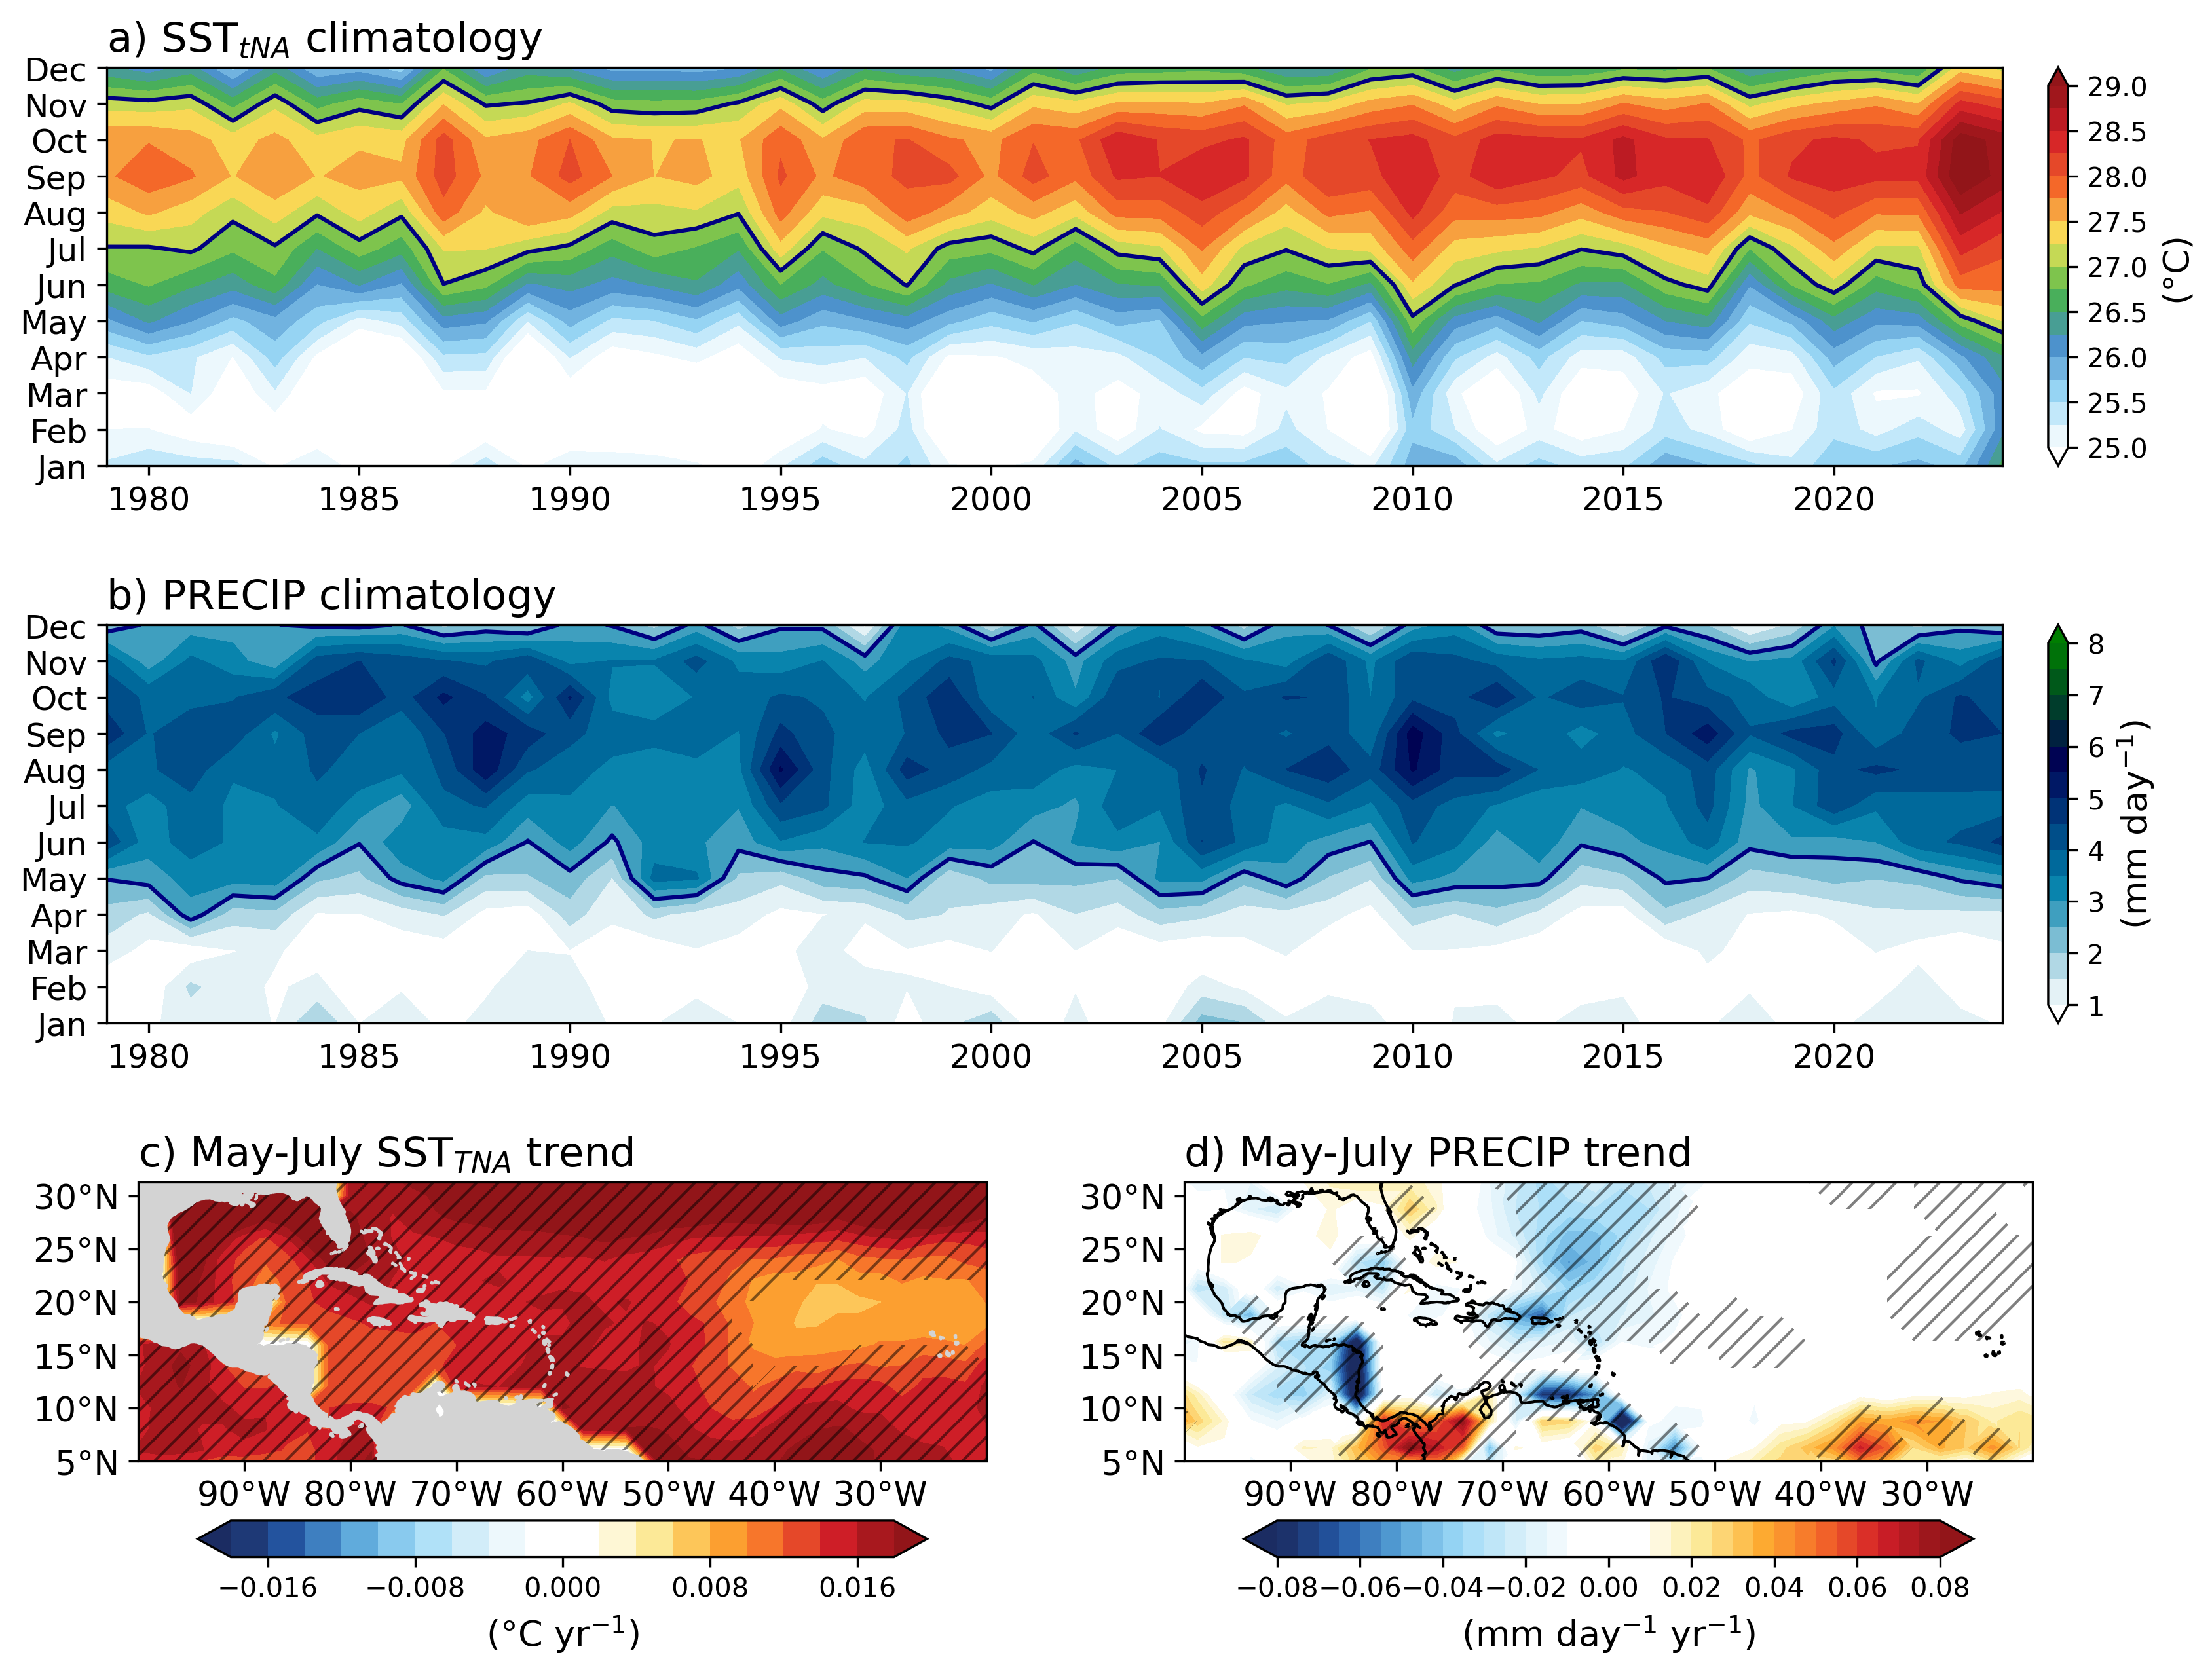

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10), dpi=300)
gs1 = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[0.9,0.1], hspace=0.4)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs1[2,0:], width_ratios=[0.475,0.475,0.1])

# Define subplots
ax1 = fig.add_subplot(gs1[0, 0:])
ax2 = fig.add_subplot(gs1[1, 0:])
ax3 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs2[0, 1], projection=ccrs.PlateCarree())


# --- Subplot 1 ---
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fc = ax1.contourf(years, months, tna_ssts_2d.T, levels=np.arange(25, 29.25, 0.25), cmap = ncl_cm.WhiteBlueGreenYellowRed, extend='both')
cntr_sst = ax1.contour(years, months, tna_ssts_2d.T, levels=[27], colors='navy', linewidths=1.5)
ax1.tick_params(labelsize=12)
cb = plt.colorbar(fc, pad=0.02)
cb.set_label('(°C)', fontsize=13)
ax1.set_title('a) SST$_{tNA}$ climatology', loc='left')

# --- Subplot 2 ---
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fc = ax2.contourf(years, months, tna_prcp_2d.T, levels=np.arange(1, 8.5, 0.5), cmap = ncl_cm.MPL_ocean_r, extend='both')
cntr_prcp = ax2.contour(years, months, tna_prcp_2d.T, levels=[2.5], colors='navy', linewidths=1.5)
ax2.tick_params(labelsize=12)
cb = plt.colorbar(fc, pad=0.02)
cb.set_label('(mm day$^{-1}$)', fontsize=13)
ax2.set_title('b) PRECIP climatology', loc='left')

# --- Subplot 3 ---
ax3.set_extent([-100, -20, 5, 25])
ax3.add_feature(cfeature.LAND, zorder=2, color='lightgray')
ax3.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.tick_params(axis='both', which='major', labelsize=12.5)

# Plot the data for the current month
levels = np.arange(-0.018, 0.020, 0.002)
im = ax3.contourf(sst_trend_results.lon.values,
                  sst_trend_results.lat.values,
                  sst_trend_results.trend.values[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Mesh the entire grid
fill = ax3.fill_between(ax3.get_xlim(), *ax3.get_ylim(), color='none', edgecolor='black', lw=0, hatch=3*'/', alpha=0.5)

# Mask trend where p_value is less than 0.05
all_trends_revmask = np.where(sst_trend_results.p_value.values < 0.05, np.nan, sst_trend_results.trend.values)

# Plot the data for the current month
im = ax3.contourf(sst_trend_results.lon.values,
                  sst_trend_results.lat.values,
                  all_trends_revmask[:, :], levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Subplot titles
ax3.set_title('c) May-July SST$_{TNA}$ trend', loc='left')

# Add a single colorbar for all subplots
cb = plt.colorbar(im, shrink=0.8, orientation='horizontal')
cb.set_label('(°C yr$^{-1}$)', fontsize=13)
cb.set_ticks(np.arange(-0.016, 0.020, 0.008))
cb.ax.tick_params(labelsize=10)

# --- Subplot 4 ---
ax4.set_extent([-100, -20, 5, 25])
ax4.add_feature(cfeature.COASTLINE, zorder=2, color='black')
ax4.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.tick_params(axis='both', which='major', labelsize=12.5)

# Plot the data for the current month
levels = np.arange(-0.08, 0.085, 0.005)
im = ax4.contourf(prcp_trend_results.lon.values,
                  prcp_trend_results.lat.values,
                  prcp_trend_results.trend.values[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both',
                  transform=ccrs.PlateCarree())

# Mesh the entire grid
fill = ax4.fill_between(ax4.get_xlim(), *ax4.get_ylim(), color='none', edgecolor='black', lw=0, hatch=3*'/', alpha=0.5)

# Mask trend where p_value is less than 0.05
all_trends_revmask = np.where(prcp_trend_results.p_value.values < 0.05, np.nan, prcp_trend_results.trend.values)

# Plot the data for the current month
im = ax4.contourf(prcp_trend_results.lon.values,
                  prcp_trend_results.lat.values,
                  all_trends_revmask[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both',
                  transform=ccrs.PlateCarree())

# Subplot titles
ax4.set_title('d) May-July PRECIP trend', loc='left')

# Add a single colorbar for all subplots
cb = plt.colorbar(im, shrink=0.8, orientation='horizontal')
cb.set_label('(mm day$^{-1}$ yr$^{-1}$)', fontsize=13)
cb.ax.tick_params(labelsize=10)

# Adjust spacing between subplots
plt.tight_layout()


Add the linear trend of SST, PRECIP onset to time series plot

In [ ]:
import pymannkendall as mk

# Generated using Gemini AI 
# Assuming 'cntr' is the contour object from the previous code
# Extract the contour lines
contour_lines = cntr_sst.get_paths()

# Initialize a list to store the contour values
contour_values_27, contour_values_yrs = [], []

# Iterate through the contour lines
for line in contour_lines:
  # Extract the vertices of the contour line
  vertices = line.vertices

  # Check if the contour line corresponds to the 27 level
  # (This might need adjustment depending on how the contour levels are handled)

  # Assuming the contour levels are stored as part of cntr object
  if np.isclose(cntr_sst.levels[0], 27):
      # Append the vertices to the list
      contour_values_27.append(vertices[:,1])
      contour_values_yrs.append(vertices[:,0])

# Print the contour values
idx = np.where(np.array(contour_values_27[0]) < 8)[0]
sst_contour_vals = contour_values_27[0][idx]
sst_contour_yrs = contour_values_yrs[0][idx]
sst_contour_yrs = np.unique(np.int64(sst_contour_yrs))

# Assuming contour_vals is defined as in the provided code
# Perform Mann-Kendall test
sst_result = mk.original_test(sst_contour_vals)

# Extract trend information
sst_trend = sst_result.trend
sst_slope = sst_result.slope

years_for_trend = np.arange(0, len(sst_contour_yrs))  # Years for trend line
sst_trnd = sst_slope * (years_for_trend - np.mean(years_for_trend)) + np.mean(sst_contour_vals)

print(f"SST Trend: {sst_trend}")
print(f"SST Slope: {sst_slope}")

SST Trend: decreasing
SST Slope: -0.019467496951352463


In [ ]:
# Assuming 'cntr' is the contour object from the previous code
# Extract the contour lines
contour_lines = cntr_prcp.get_paths()

# Initialize a list to store the contour values
contour_values_prcp, contour_values_yrs = [], []

# Iterate through the contour lines
for line in contour_lines:
  # Extract the vertices of the contour line
  vertices = line.vertices

  # Check if the contour line corresponds to the 2.5-mm level
  # (This might need adjustment depending on how the contour levels are handled)

  # Assuming the contour levels are stored as part of cntr object
  if np.isclose(cntr_prcp.levels[0], 2.5):
      # Append the vertices to the list
      contour_values_prcp.append(vertices[:,1])
      contour_values_yrs.append(vertices[:,0])

# Print the contour values
idx = np.where(np.array(contour_values_prcp[0]) < 8)[0]
prcp_contour_vals = contour_values_prcp[0][idx]
prcp_contour_yrs = contour_values_yrs[0][idx]
prcp_contour_yrs = np.unique(np.int64(prcp_contour_yrs))

# Assuming contour_vals is defined as in the provided code
# Perform Mann-Kendall test
prcp_result = mk.original_test(prcp_contour_vals)

# Extract trend information
prcp_trend = prcp_result.trend
prcp_slope = prcp_result.slope

years_for_trend = np.arange(0, len(prcp_contour_yrs))  # Years for trend line
prcp_trnd = prcp_slope * (years_for_trend - np.mean(years_for_trend)) + np.mean(prcp_contour_vals)

print(f"Precipitation Trend: {prcp_trend}")
print(f"Precipitation Slope: {prcp_slope}")

Precipitation Trend: no trend
Precipitation Slope: 0.0008020985555068069


Now, add the onset trend lines to panels 1 and 2. This is the final plot.

/Users/jjpjones/miniconda3/envs/breaking-env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/jjpjones/miniconda3/envs/breaking-env/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/9r/1fy75c596lz3lxy_jxjy5g_r0002g0/T/ipykernel_68193/1894751336.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


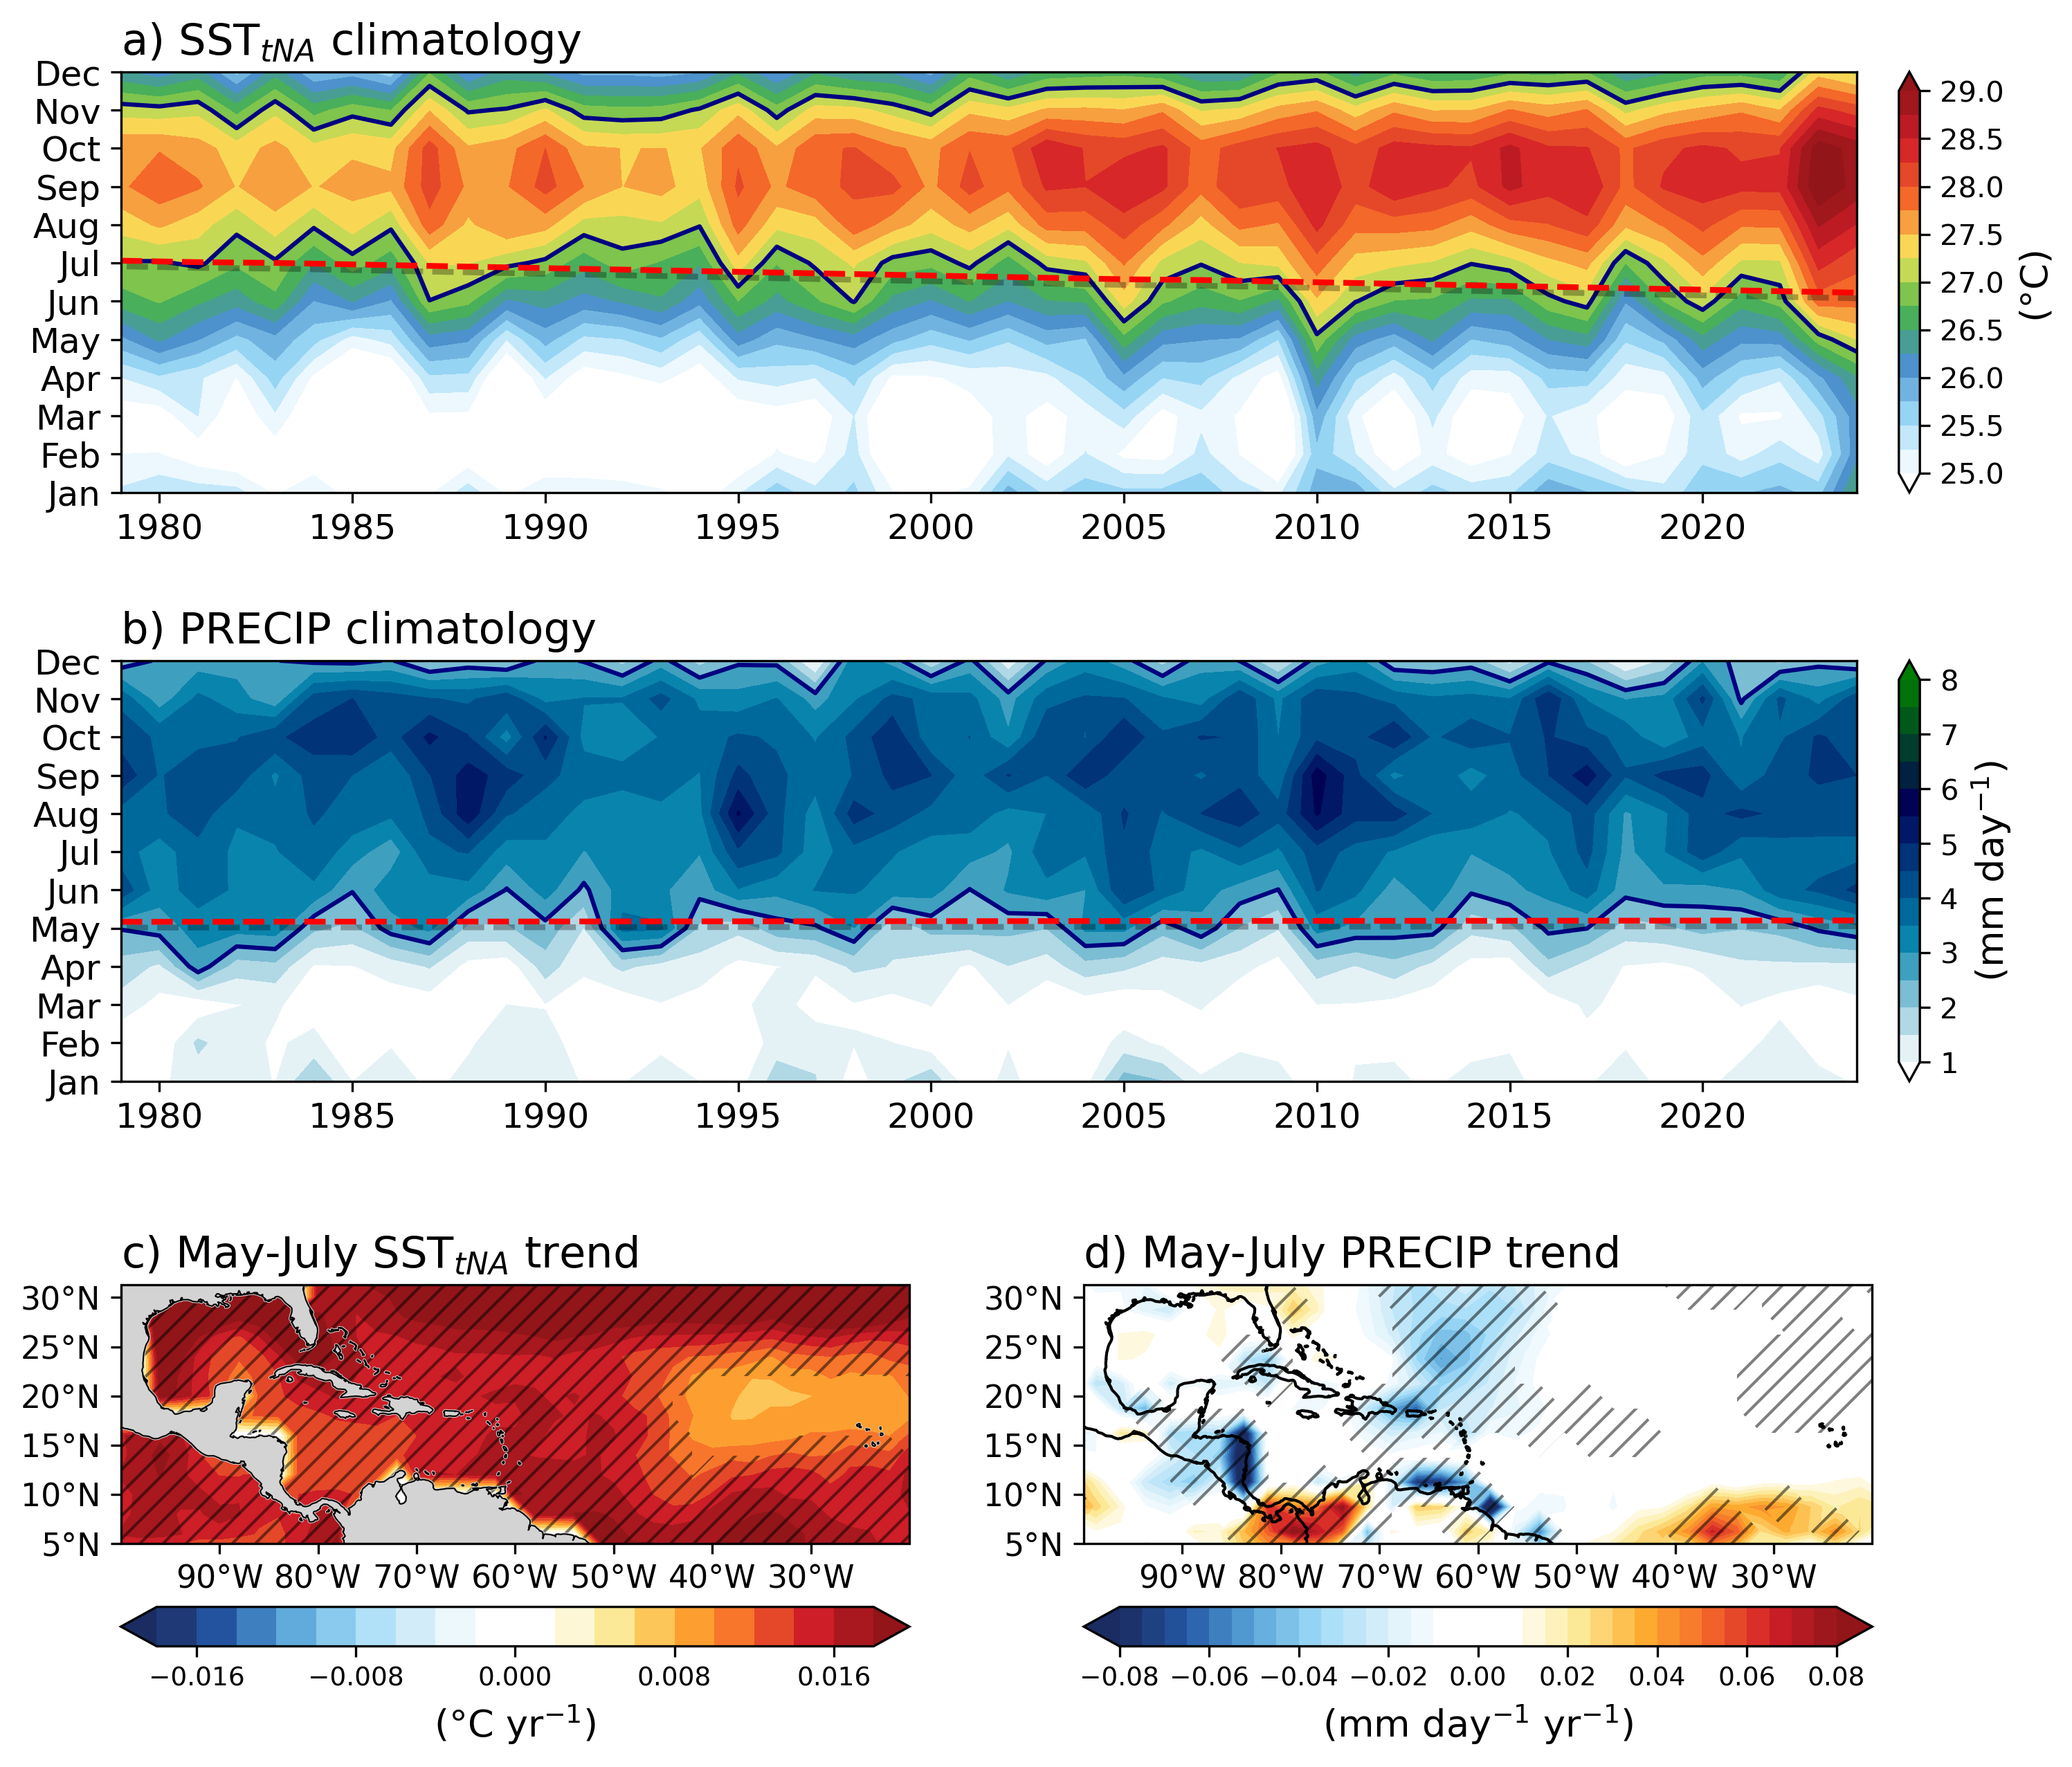

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.patheffects import PathPatchEffect, SimpleLineShadow, Normal

fig = plt.figure(figsize=(13, 10), dpi=300)
gs1 = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[0.9,0.1], hspace=0.4)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs1[2,0:], width_ratios=[0.475,0.475,0.1], wspace=0.3)

# Define subplots
ax1 = fig.add_subplot(gs1[0, 0:])
ax2 = fig.add_subplot(gs1[1, 0:])
ax3 = fig.add_subplot(gs2[0, 0], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs2[0, 1], projection=ccrs.PlateCarree())


# --- Subplot 1 ---
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fc = ax1.contourf(years, months, tna_ssts_2d.T, levels=np.arange(25, 29.25, 0.25), cmap = ncl_cm.WhiteBlueGreenYellowRed, extend='both')
cntr_sst = ax1.contour(years, months, tna_ssts_2d.T, levels=[27], colors='navy', linewidths=1.5)
trnd = ax1.plot(sst_contour_yrs, sst_trnd,  label='Linear Trend', ls='--', color='red', linewidth=2, path_effects=[SimpleLineShadow(shadow_color="black", linewidth=2),Normal()])
ax1.tick_params(labelsize=12)
cb = plt.colorbar(fc, pad=0.02)
cb.set_label('(°C)', fontsize=13)
ax1.set_title('a) SST$_{tNA}$ climatology', loc='left')

# --- Subplot 2 ---
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fc = ax2.contourf(years, months, tna_prcp_2d.T, levels=np.arange(1, 8.5, 0.5), cmap = ncl_cm.MPL_ocean_r, extend='both')
cntr_prcp = ax2.contour(years, months, tna_prcp_2d.T, levels=[2.5], colors='navy', linewidths=1.5)
trnd = ax2.plot(prcp_contour_yrs, prcp_trnd, label='Linear Trend', ls='--', color='red', linewidth=2, path_effects=[SimpleLineShadow(shadow_color="black", linewidth=2),Normal()])
ax2.tick_params(labelsize=12)
cb = plt.colorbar(fc, pad=0.02)
cb.set_label('(mm day$^{-1}$)', fontsize=13)
ax2.set_title('b) PRECIP climatology', loc='left')

# --- Subplot 3 ---
ax3.set_extent([-100, -20, 5, 25])
ax3.add_feature(cfeature.LAND, zorder=2, color='lightgray')
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2, color='black')
ax3.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.tick_params(axis='both', which='major', labelsize=11)

# Plot the data for the current month
levels = np.arange(-0.018, 0.020, 0.002)
im = ax3.contourf(sst_trend_results.lon.values,
                  sst_trend_results.lat.values,
                  sst_trend_results.trend.values[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Mesh the entire grid
fill = ax3.fill_between(ax3.get_xlim(), *ax3.get_ylim(), color='none', edgecolor='black', lw=0, hatch=3*'/', alpha=0.5)

# Mask trend where p_value is less than 0.05
all_trends_revmask = np.where(sst_trend_results.p_value.values < 0.05, np.nan, sst_trend_results.trend.values)

# Plot the data for the current month
im = ax3.contourf(sst_trend_results.lon.values,
                  sst_trend_results.lat.values,
                  all_trends_revmask[:, :], levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both', transform=ccrs.PlateCarree())

# Subplot titles
ax3.set_title('c) May-July SST$_{tNA}$ trend', loc='left')

# Add a single colorbar for all subplots
cb = plt.colorbar(im, orientation='horizontal')
cb.set_label('(°C yr$^{-1}$)', fontsize=13)
cb.set_ticks(np.arange(-0.016, 0.020, 0.008))
cb.ax.tick_params(labelsize=9)

# --- Subplot 4 ---
ax4.set_extent([-100, -20, 5, 25])
ax4.add_feature(cfeature.COASTLINE, zorder=2, color='black')
ax4.set_xticks(np.arange(-90, -20, 10), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(5, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.tick_params(axis='both', which='major', labelsize=11)

# Plot the data for the current month
levels = np.arange(-0.08, 0.085, 0.005)
im = ax4.contourf(prcp_trend_results.lon.values,
                  prcp_trend_results.lat.values,
                  prcp_trend_results.trend.values[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both',
                  transform=ccrs.PlateCarree())

# Mesh the entire grid
fill = ax4.fill_between(ax4.get_xlim(), *ax4.get_ylim(), color='none', edgecolor='black', lw=0, hatch=3*'/', alpha=0.5)

# Mask trend where p_value is less than 0.05
all_trends_revmask = np.where(prcp_trend_results.p_value.values < 0.05, np.nan, prcp_trend_results.trend.values)

# Plot the data for the current month
im = ax4.contourf(prcp_trend_results.lon.values,
                  prcp_trend_results.lat.values,
                  all_trends_revmask[:, :],
                  levels=levels,
                  cmap=ncl_cm.BlueWhiteOrangeRed, extend='both',
                  transform=ccrs.PlateCarree())

# Subplot titles
ax4.set_title('d) May-July PRECIP trend', loc='left')

# Add a single colorbar for all subplots
cb = plt.colorbar(im, orientation='horizontal')
cb.set_label('(mm day$^{-1}$ yr$^{-1}$)', fontsize=13)
cb.ax.tick_params(labelsize=9)

# Adjust spacing between subplots
plt.tight_layout()

# --- Save figure ---
fig.savefig('../figures/figure2_sst_precip_trend.pdf', dpi=300, format='pdf', bbox_inches='tight')

## Warming rates in the Caribbean and tropical North Atlantic

In [11]:
warming_avg = sst_trend_results.trend.sel(lat=slice(25,5), lon=slice(360-80, 360-15)).mean()
drying_avg = prcp_trend_results.trend.sel(lat=slice(5,25), lon=slice(360-80, 360-15)).mean()

car_warming_avg = sst_trend_results.trend.sel(lat=slice(25,5), lon=slice(360-90, 360-60)).mean()
car_drying_avg = prcp_trend_results.trend.sel(lat=slice(5,25), lon=slice(360-90, 360-60)).mean()

print('# --- Tropical North Atlantic ---')
print('Average warming over the TNA is '+ str(np.round(warming_avg.values, decimals=3))+ '°C.')
print('Average drying over the TNA is '+ str(np.round(drying_avg.values, decimals=3))+ 'mm day$^{-1}$.')

print(' ')
print('# --- Caribbean ---')
print('Average warming over the Caribbean is '+ str(np.round(car_warming_avg.values, decimals=3))+ '°C.')
print('Average drying over the Caribbean is '+ str(np.round(car_drying_avg.values, decimals=3))+ 'mm day$^{-1}$.')

# --- Tropical North Atlantic ---
Average warming over the TNA is 0.013°C.
Average drying over the TNA is -0.001mm day$^{-1}$.
 
# --- Caribbean ---
Average warming over the Caribbean is 0.012°C.
Average drying over the Caribbean is -0.008mm day$^{-1}$.
